## Shortlist d'articles

Le but de ce notebook est de déterminer une liste restreinte d'articles, statique ou dynamique, qui sera utilisée pour les modélisations.

On se basera pour cela sur les ventes, couplées aux critères suivants : 
- Groupe de client
- Groupe de code postal
- Âge du client
- Catégories préférées par le client
- Articles susceptibles d'être rachetés
- Articles qui vont de pair avec des articles déjà achetés

**L'idée est de déterminer une liste de 50 articles par client, sur la base de laquelle le score maximal obtenu sera satisfaisant.**

In [2]:
import pandas as pd
import numpy as np
import swifter
from utils.map12_from_score_table import map12_from_score_table
from utils.map12_from_series import map12_from_series

ages_centers = [15, 25, 35, 45, 55, 65]

def get_maximum_score(purchased_articles, shortlist):
    """Get the maximum (linear) score that can be obtained with an article shortlist.

    Args:
        purchased_articles (pd.Series): Series containing the list of purchased article for each customer.
        shortlist (pd.Series): Series containing the shortlist of articles for each customer.
        
        
    Returns:
        A pd.Series object containing the maximum linear score for each customer.
    """
    return pd.concat([purchased_articles.rename('purchased_articles'), shortlist.rename('shortlist')], axis = 1).apply(
        lambda x: min( 
            np.sum(
                np.where(
                    [article in x.purchased_articles for article in x.shortlist], # Gives one sub-point for right article.
                    1, 
                    0
                )
            ) / min(len(x.purchased_articles), 12), # Predict 12 articles is sufficient for having the maximum score.
            1 # The max score is 1 per article.
        ),
    axis=1)

def max_score_curve(purchased_articles, shortlist, max = 100, step = 5):
    curve = [0]
    
    length = len(shortlist)
    
    score = 0
    
    for i in np.arange(0, max, step):
        print(f"\r Calcul pour les articles 1-{i}", end="")
        score += get_maximum_score(
                purchased_articles,
                shortlist.apply(lambda x: x[i: i + step])
            ).sum() / length
            
        curve.append(
            score
        )
    
    return curve

### Création des données de validation
Sur la base de la dernière semaine du jeu de données.

In [2]:
transactions = pd.read_pickle('pickles/transactions_clean.pkl')
transactions_last_week = transactions[transactions['week_number'] == 0]

In [3]:
validation_purchases = transactions_last_week.groupby(['customer_id'], as_index = False).agg(
    purchase_list = ('article_id', lambda x: list(x))
)

### Création des listes pour chaque Client
Ici, on travaille uniquement sur les clients qui ont des achats.

In [4]:
# Création d'une table Clients destinée à 
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')

# Ajout de la liste des achats effectués.
validation_customers = validation_purchases[['customer_id']].merge(customers, on = 'customer_id', how = 'left')

# Suppression des features inutiles pour la génération des listes.
validation_customers.drop(['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'repurchases', 'repurchases_interval'], 1, inplace = True)


In [5]:
# Création d'un index des ventes sur l'avant-dernière semaine.
before_last_week_sales = transactions[transactions['week_number'] == 1]

before_last_week_sales = transactions[transactions['week_number'] == 1].merge(customers, on = 'customer_id', how = 'left')

top_sales_validation = before_last_week_sales.groupby(['article_id', 'postal_code_group', 'group'], as_index = False).agg(
    sales = ('article_id', 'count'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

top_sales_validation = top_sales_validation.merge(articles[['article_id', 'index_group_name']], on = 'article_id')
top_sales_validation.head()

,article_id,postal_code_group,group,sales,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,index_group_name
0,0108775044,4,4,1,0.0,0.0,0.0,0.2,0.8,0.0,Ladieswear
1,0108775044,5,11,1,0.0,0.3,0.7,0.0,0.0,0.0,Ladieswear
2,0111565001,1,6,1,0.0,0.0,0.0,0.5,0.5,0.0,Ladieswear
3,0111565001,1,9,1,0.1,0.9,0.0,0.0,0.0,0.0,Ladieswear
4,0111565001,1,11,1,0.0,0.5,0.5,0.0,0.0,0.0,Ladieswear


#### Articles les plus vendus
Génération de la liste des articles les plus vendus, toute catégorie / âge etc confondus.

In [6]:
top_sales_general = top_sales_validation.groupby('article_id', as_index = False)['sales'].sum().nlargest(n = 100, columns="sales")['article_id'].tolist()
validation_customers['best_articles'] = validation_customers['customer_id'].apply(lambda x: top_sales_general)
validation_customers[['customer_id', 'best_articles']].head(5)

,customer_id,best_articles
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,"[0909370001, 0865799006, 0918522001, 092424300..."
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"[0909370001, 0865799006, 0918522001, 092424300..."
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0909370001, 0865799006, 0918522001, 092424300..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,"[0909370001, 0865799006, 0918522001, 092424300..."
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0909370001, 0865799006, 0918522001, 092424300..."


#### Articles les plus vendus par groupe de code postal

In [7]:
postal_code_groups = top_sales_validation['postal_code_group'].unique()

postal_codes_lists = {}

top_sales_postal_code_groups = top_sales_validation.groupby(['article_id', 'postal_code_group'], as_index = False)['sales'].sum()

for group in postal_code_groups :
    postal_codes_lists[group] = top_sales_postal_code_groups[top_sales_postal_code_groups['postal_code_group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['postal_group_articles'] = validation_customers['postal_code_group'].apply(lambda x: postal_codes_lists[x])

validation_customers[['customer_id', 'postal_group_articles']].head(5)

,customer_id,postal_group_articles
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,"[0909370001, 0751471001, 0865799006, 091852200..."
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"[0909370001, 0865799006, 0924243001, 091852200..."
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0909370001, 0751471001, 0865799006, 091852200..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,"[0909370001, 0918522001, 0924243001, 086579900..."
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0909370001, 0918522001, 0706016001, 091829200..."


#### Classement par groupe d'utilisateur

In [8]:
customer_groups = top_sales_validation['group'].unique()

customer_group_lists = {}

top_sales_customer_groups = top_sales_validation.groupby(['article_id', 'group'], as_index = False)['sales'].sum()

for group in customer_groups :
    customer_group_lists[group] = top_sales_customer_groups[top_sales_customer_groups['group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['customer_group_articles'] = validation_customers['group'].apply(lambda x: customer_group_lists[x])

#### Classement par catégorie

In [9]:
categories = top_sales_validation['index_group_name'].unique()
categories_string = []

top_sales_categories = top_sales_validation.groupby(['article_id', 'index_group_name'], as_index = False)['sales'].sum()

top_sales_category_lists = {}

for category in categories:
    category_string = category.split('/')[0].lower()
    categories_string.append(category_string)
    
    top_sales_category_lists[category_string] = top_sales_categories[top_sales_categories['index_group_name'] == category].nlargest(n = 100, columns = ['sales'])
    top_sales_category_lists[category_string]['shares'] = top_sales_category_lists[category_string]['sales'] / top_sales_category_lists[category_string]['sales'].sum()
    top_sales_category_lists[category_string]['index_group_name'] = category_string


In [10]:
def get_category_list(x, balanced = False):
    global categories
    global top_sales_category_lists
    
    top_sales_weighted = []
    
    for category in categories_string:
    
        if x[category] == 0:
            continue
        
        column = 'shares' if balanced else 'sales'
        
        top_sales_category_lists[category]['sales_weighted'] = top_sales_category_lists[category][column] * x[category]
        
        top_sales_weighted.append(top_sales_category_lists[category])
        
    return pd.concat(top_sales_weighted).nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()

def get_category_list_weighted(x):
    return get_category_list(x, balanced = True)

In [11]:
validation_customers['category_list'] = validation_customers.swifter.apply(get_category_list, axis = 1)


Pandas Apply: 100%|██████████| 68984/68984 [01:20<00:00, 857.98it/s]


In [12]:
# liste utilisant les parts de vente dans chaque catégorie et non les ventes en valeur absolue.
validation_customers['category_list_balanced'] = validation_customers.swifter.apply(get_category_list_weighted, axis = 1)

Pandas Apply: 100%|██████████| 68984/68984 [01:17<00:00, 884.82it/s]


#### Classement par âge (pondération discrète)

In [13]:
customer_age_lists = {}

top_sales_ages = top_sales_validation.groupby('article_id', as_index = False).agg(
    sales = ('sales', 'sum'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

validation_customers['age_articles'] = ''

for age in ages_centers :
    age_list = top_sales_ages.nlargest(n = 100, columns=f"age_around_{age}")['article_id'].tolist()
    
    validation_customers['age_articles'] = validation_customers.apply(
        lambda x: 
            age_list if x[f"age_around_{age}"] > 0.5 
            else x['age_articles']
        , axis = 1
    )

#### Classement par âge (pondération continue)

In [14]:
def age_weighted_list(x):
    global top_sales_ages
    
    top_sales_ages['sales_weighted'] = 0
    
    for age in ages_centers:
        column = f'age_around_{age}'
        top_sales_ages['sales_weighted'] += top_sales_ages[column] * x[column]
        
    return top_sales_ages.nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()


validation_customers['age_articles_weighted'] = validation_customers.swifter.apply(age_weighted_list, axis = 1)

Pandas Apply: 100%|██████████| 68984/68984 [02:23<00:00, 482.15it/s]


In [15]:
validation_purchases.to_pickle('pickles/second_iteration_validation_purchases.pkl')
validation_customers.to_pickle('pickles/second_iteration_shortlists.pkl')

In [16]:
best_articles_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['best_articles'])

 Calcul pour les articles 1-95

In [17]:
postal_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['postal_group_articles'])

 Calcul pour les articles 1-95

In [18]:
customer_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['customer_group_articles'])

 Calcul pour les articles 1-95

In [19]:
category_list_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['category_list'])

 Calcul pour les articles 1-95

In [27]:
category_list_balanced_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['category_list_balanced'])

 Calcul pour les articles 1-95

In [21]:
age_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['age_articles'])

 Calcul pour les articles 1-95

In [26]:
age_weighted_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['age_articles_weighted'])

 Calcul pour les articles 1-95

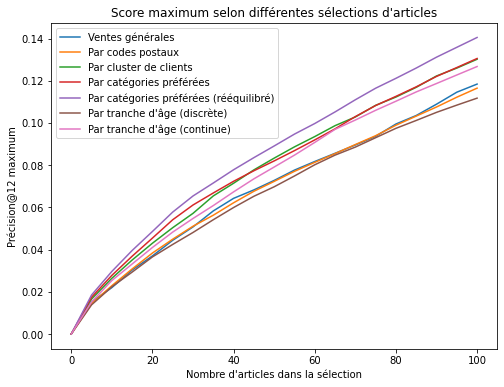

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 101, 5)

plt.figure(figsize = (8, 6))
plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, postal_group_curve, label = "Par codes postaux")
plt.plot(x, customer_group_curve, label = "Par cluster de clients")
plt.plot(x, category_list_curve, label = "Par catégories préférées")
plt.plot(x, category_list_balanced_curve, label = "Par catégories préférées (rééquilibré)")
plt.plot(x, age_curve, label = "Par tranche d'âge (discrète)")
plt.plot(x, age_weighted_curve, label = "Par tranche d'âge (continue)")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Précision@12 maximum")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()

Les listes par âge (pondération continue), clustering de clients et surtout catégories préférées rééquilibrée offrent un gain potentiel significatif.
Il serait donc opportun de croiser ses différentes listes.

#### Sélection croisée Groupe / Catégorie / Âge

In [38]:
# Préparation des classements.

groups = top_sales_validation['group'].unique()
categories = top_sales_validation['index_group_name'].unique()

cross_lists = {}

top_sales_validation['index_group_name'] = top_sales_validation['index_group_name'].astype(str)

top_sales_cross = top_sales_validation.groupby(['article_id', 'index_group_name', 'group'], as_index = False).agg(
    sales = ('sales', 'sum'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

for group in groups :
    cross_lists[group] = {}
    
    categories = top_sales_validation['index_group_name'].unique()

    for category in categories:
        category_string = category.split('/')[0].lower()
        
        cross_lists[group][category_string] = top_sales_cross[(top_sales_cross['group'] == group) & (top_sales_cross['index_group_name'] == category)]
        cross_lists[group][category_string]['shares'] = cross_lists[group][category_string]['sales'] / cross_lists[group][category_string]['sales'].sum()
        cross_lists[group][category_string]['index_group_name'] = category_string
        cross_lists[group][category_string] = cross_lists[group][category_string].nlargest(n = 100, columns = 'shares')

/tmp/ipykernel_8145/611996942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_lists[group][category_string]['shares'] = cross_lists[group][category_string]['sales'] / cross_lists[group][category_string]['sales'].sum()
/tmp/ipykernel_8145/611996942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_lists[group][category_string]['index_group_name'] = category_string


In [2]:
def get_cross_list(x):
    global cross_lists
    
    top_sales_weighted = []
    group = x['group']
    
    for category in cross_lists[group].keys():
    
        if x[category] == 0:
            continue
        
        cross_lists[group][category]['shares_weighted'] = cross_lists[group][category]['shares'] * x[category]
        cross_lists[group][category]['sales_cross_weighted'] = 0
            
        for age in ages_centers:
            column = f"age_around_{age}"
            
            if x[column] == 0:
                continue
            
            cross_lists[group][category]['sales_cross_weighted'] += cross_lists[group][category][column] * cross_lists[group][category]['shares_weighted']
            
            top_sales_weighted.append(cross_lists[group][category])
    
    if len(top_sales_weighted) == 0:
        return []
    
    final_list = pd.concat(top_sales_weighted).groupby('article_id', as_index = False).agg(
        sales_cross_weighted = ('sales_cross_weighted', 'max')
    )
    
    return final_list.nlargest(n = 100, columns = ['sales_cross_weighted'])['article_id'].tolist()

In [41]:
cross_list = validation_customers.swifter.apply(lambda x: get_cross_list(x), axis = 1)

Pandas Apply: 100%|██████████| 68984/68984 [05:24<00:00, 212.56it/s]


In [43]:
validation_customers['cross_list'] = cross_list

In [ ]:
cross_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['cross_list'])

In [20]:
validation_purchases = pd.read_pickle('pickles/second_iteration_validation_purchases.pkl')
validation_customers = pd.read_pickle('pickles/second_iteration_shortlists.pkl')

#### Articles susceptibles d'être rachetés

In [21]:
already_purchased_list = pd.read_pickle('pickles/already_purchased_list_train.pkl')

already_purchased_list = validation_purchases[['customer_id']].merge(already_purchased_list, on = 'customer_id', how = 'left')

In [22]:
already_purchased_list[already_purchased_list['list'].isna()] = already_purchased_list[already_purchased_list['list'].isna()].fillna('').apply(list)

In [ ]:
repurchase_curve = max_score_curve(validation_purchases['purchase_list'], already_purchased_list['list'])

#### Paires d'articles
Articles qui sont en général achetés ensemble 

In [23]:
pairs_list = pd.read_pickle("pickles/articles_pairs_list_training.pkl")

pairs_list = validation_purchases[['customer_id']].merge(pairs_list, on = 'customer_id', how = 'left')
pairs_list[pairs_list['list'].isna()] = pairs_list[pairs_list['list'].isna()].fillna('').apply(list)

In [24]:
pairs_curve = max_score_curve(validation_purchases['purchase_list'], pairs_list['list'])

 Calcul pour les articles 1-95

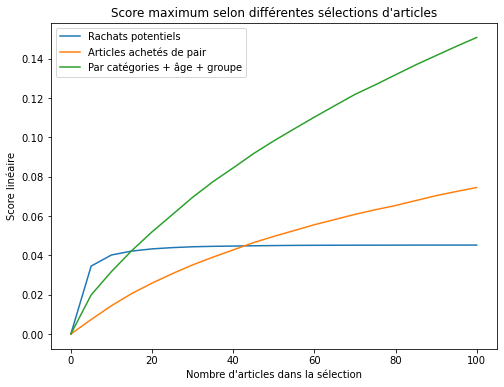

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 101, 5)

plt.figure(figsize = (8, 6))
#plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, repurchase_curve, label = "Rachats potentiels")
plt.plot(x, pairs_curve, label = "Articles achetés de pair")
plt.plot(x, cross_curve, label = "Par catégories + âge + groupe")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Score linéaire")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()

**Observations**
- Les trois listes semblent prometteuses.
- La liste croisée catégorie / âge / groupe est meilleure que la courbe par catégorie, mais de très peu.

#### Détermination du nombre optimal d'articles de chaque liste

In [ ]:
# Courbes plus précises
cross_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['cross_list'], 100, 1)
repurchase_curve = max_score_curve(validation_purchases['purchase_list'], already_purchased_list['list'], 100, 1)
pairs_curve = max_score_curve(validation_purchases['purchase_list'], pairs_list['list'], 100, 1)

In [27]:
def amount_of_each_list(score_list_1, score_list_2, score_list_3, length):
    i_1 = 1
    i_2 = 1
    i_3 = 1
    
    for n in range(0, length):
        score_1 = score_list_1[i_1] - score_list_1[i_1 - 1]
        score_2 = score_list_2[i_2] - score_list_2[i_2 - 1]
        score_3 = score_list_3[i_3] - score_list_3[i_3 - 1]
        
        
        if score_1 >= score_2 and score_1 >= score_3 :
            i_1 += 1
        elif score_2 >= score_3 :
            i_2 += 1
        else :
            i_3 += 1
            
    return i_1 - 1, i_2 - 1, i_3 - 1
            

In [31]:
i_1, i_2, i_3 = amount_of_each_list(repurchase_curve, cross_curve, pairs_curve, 12)
print(f"Pour une liste de 12 éléments, prendre : \n {i_1} rachats \n {i_2} articles de la liste croisée, \n {i_3} articles appairés. ")

Pour une liste de 12 éléments, prendre : 
 4 rachats 
 8 articles de la liste croisée, 
 0 articles appairés. 


In [32]:
i_1, i_2, i_3 = amount_of_each_list(repurchase_curve, cross_curve, pairs_curve, 100)
print(f"Pour une liste de 100 éléments, prendre : \n {i_1} rachats \n {i_2} articles de la liste croisée, \n {i_3} articles appairés. ")

Pour une liste de 100 éléments, prendre : 
 7 rachats 
 68 articles de la liste croisée, 
 25 articles appairés. 


### Évaluation de la liste finale

In [25]:
validation_purchases['cross_list'] = validation_customers['cross_list']
validation_purchases['pair_list'] = pairs_list['list']
validation_purchases['repurchase_list'] = already_purchased_list['list']

In [26]:
validation_purchases['length'] = validation_purchases['cross_list'].apply(lambda x: len(x))
validation_purchases['length'].value_counts()
validation_purchases = validation_purchases[validation_purchases['length'] == 100]

In [9]:
def process_shortlist(raw):
    shortlist = []
    
    i_1 = 0
    i_2 = 0
    i_3 = 0
    
    while (len(shortlist) < 100) & (i_3 < len(raw['cross_list'])):
        if i_1 < 7 and i_1 < len(raw['repurchase_list']):
            article_id = raw['repurchase_list'][i_1]
            i_1 += 1
        elif i_2 < 25 and i_2 < len(raw['pair_list']):
            article_id = raw['pair_list'][i_2]
            i_2 += 1
        else:
            article_id = raw['cross_list'][i_3]
            i_3 += 1
    
        if article_id not in shortlist:
            shortlist.append(article_id)
            
    return shortlist

validation_purchases['shortlist'] = validation_purchases.swifter.apply(lambda x: process_shortlist(x), axis = 1)

In [47]:
max_score = get_maximum_score(validation_purchases['purchase_list'], validation_purchases['shortlist']).sum() / len(validation_purchases)

print("Score linéaire maximal obtenu par la shortlist: ", max_score)

Pandas Apply: 100%|██████████| 68439/68439 [00:22<00:00, 3029.28it/s]

Score linéaire maximal obtenu par la shortlist:  0.1822552817544708


In [28]:
validation_purchases.to_pickle('pickles/article_lists_train.pkl')
validation_purchases.head()

,customer_id,purchase_list,cross_list,pair_list,repurchase_list,length,shortlist
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,[0624486001],"[0909370001, 0924243001, 0865799006, 091852200...","[0111593001, 0111593001, 0123173001, 011158600...",,100,"[0111593001, 0123173001, 0111586001, 015834000..."
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,[0827487003],"[0805947001, 0809238005, 0809238001, 071479002...","[0377277002, 0759871002, 0759871002, 075987100...","[0621381012, 0880017001, 0640021012]",100,"[0621381012, 0880017001, 0640021012, 037727700..."
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0640021019, 0757926001, 0788575004]","[0448509014, 0706016002, 0715624001, 070601600...","[0759871002, 0759871002, 0759871002, 070601600...","[0556255001, 0399136061, 0732842021, 073284201...",100,"[0556255001, 0399136061, 0732842021, 073284201..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,[0874110016],"[0809238005, 0809238001, 0448509014, 080594700...",,,100,"[0809238005, 0809238001, 0448509014, 080594700..."
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0915529005, 0158340001, 0448509014, 048663900...","[0909370001, 0918522001, 0924243001, 086579900...","[0158340001, 0759871002, 0759871001, 070601600...","[0806388001, 0933989002, 0456163060, 092974400...",100,"[0806388001, 0933989002, 0456163060, 092974400..."


### Conclusion

- Entraîner un algorithme sur la shortlist permettrait d'obtenir une précision à 12 maximale de 0.18. Cette limite est très supérieure aux scores obtenus sur la compétition (~0.035) et nous pouvons donc la considérer comme acceptable dans un premier temps.
- Le score maximal obtenu pour des listes fait intervenir des notions séquentielles, de relations entre les articles (rachat + articles appairés) et / ou d'historique d'achat du client. Nous sommes donc confortés dans l'idée qu'un modèle de type RNN / GNN serait approprié sur cette problématique.

### Annexe - Crosslist pour le jeu de données de test
- Génération de la crosslist pour l'ensemble des clients à partir des données de la semaine 0.

In [3]:

def top_sales_cross_lists(week_sales):
    """Création des listings nécessaires à l'élaboration de la liste croisée âge / catégorie / groupe.

    Args:
        week_sales (pd.DataFrame): Les transactions pour la semaine choisie

    Returns:
        dictionnary: Listes par groupe et par catégorie, avec les pondérations par âge.
    """
    global articles
    global customers
    
    top_sales = week_sales.merge(customers, on = 'customer_id', how = 'left')
    
    top_sales = top_sales.groupby(['article_id', 'group'], as_index = False).agg(
        sales = ('article_id', 'count'),
        age_around_15 = ('age_around_15', 'sum'),
        age_around_25 = ('age_around_25', 'sum'),
        age_around_35 = ('age_around_35', 'sum'),
        age_around_45 = ('age_around_45', 'sum'),
        age_around_55 = ('age_around_55', 'sum'),
        age_around_65 = ('age_around_65', 'sum'),
    )
    
    top_sales = top_sales.merge(articles[['article_id', 'index_group_name']], on = 'article_id')
    
    top_sales['index_group_name'] = top_sales['index_group_name'].apply(lambda x: x.split('/')[0].lower())
    
    # Préparation des listes.

    groups = top_sales['group'].unique()
    categories = top_sales['index_group_name'].unique()

    cross_lists = {}

    for group in groups :
        cross_lists[group] = {}
        
        categories = top_sales['index_group_name'].unique()

        for category in categories:
            
            cross_lists[group][category] = top_sales[(top_sales['group'] == group) & (top_sales['index_group_name'] == category)]
            cross_lists[group][category]['shares'] = cross_lists[group][category]['sales'] / cross_lists[group][category]['sales'].sum()
            cross_lists[group][category]['index_group_name'] = category
            cross_lists[group][category] = cross_lists[group][category].nlargest(n = 100, columns = 'shares')
        
    
    return cross_lists

In [4]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [ ]:
transactions = pd.read_pickle('pickles/transactions_clean.pkl')
cross_lists = top_sales_cross_lists(transactions[transactions['week_number'] == 0])

In [ ]:
# Génération de la cross-list par blocs de 50 000 clients.
length = len(customers)
chunks = []
index = 0
rows_by_block = 100000

while index < length:
    print(f"\r Traitement des lignes {index}-{index + rows_by_block}       ", end = "")
    end = min(index * rows_by_block, length)

    chunk = customers.loc[index : min(index + rows_by_block, length) - 1].swifter.apply(lambda x: get_cross_list(x), axis = 1)
    
    chunks.append(chunk)
    
    index += rows_by_block

In [ ]:
for i in range(len(chunks)):
    #chunks[i].to_pickle(f"pickles/cross_list_chunk_{i}.pkl")
    chunks[i] = chunks[i].iloc[0:100000]
    print("Taille du chunk:", len(chunks[i]))

In [12]:
cross_list = pd.concat(chunks)

In [10]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,average_cart_articles,average_cart_price,total_carts,...,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.900000,0.054393,10,...,0.0,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4,6
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,3.250000,0.100510,24,...,14.0,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4,9
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,2.142857,0.086646,7,...,1.0,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4,9
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,2.000000,0.060983,1,...,0.0,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1,4
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,2.166667,0.078282,6,...,1.0,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,0,ACTIVE,None,24,7aa399f7e669990daba2d92c577b52237380662f36480b...,4.090909,0.105169,11,...,3.0,22.333333,0.1,0.9,0.0,0.0,0.0,0.0,4,9
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0,0,ACTIVE,None,21,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...,4.315789,0.092521,19,...,3.0,0.666667,0.4,0.6,0.0,0.0,0.0,0.0,1,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1,1,ACTIVE,Regularly,21,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...,2.263158,0.039740,19,...,3.0,0.000000,0.4,0.6,0.0,0.0,0.0,0.0,4,0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1,1,ACTIVE,Regularly,18,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...,1.750000,0.052301,4,...,1.0,2.000000,0.7,0.3,0.0,0.0,0.0,0.0,3,0


In [14]:
cross_list.to_pickle('pickles/cross_list.pkl')

In [3]:
cross_list = pd.read_pickle('pickles/cross_list.pkl')
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')

In [4]:
pairs_list = pd.read_pickle("pickles/articles_pairs_list.pkl")
pairs_list.head()

,customer_id,list
0,02054367e574c7287a453fb3ae3174b8d5fa968ab1c418...,"[0832482001, 0820484001, 0837351001, 083441201..."
1,04e2301dc0581c5b443429e1614cf21ffe9b23d8d3fe05...,"[0706104010, 0783969004, 0834799001, 068581600..."
2,0456515f18cdd341dbb0077191bcd67e9e7738d81ed4f9...,"[0847959002, 0803592003, 0798827001, 077290200..."
3,0444412a01c8d761fa55b19bd29cf07bd80bfcbe82275a...,"[0568601029, 0448515033, 0671444001, 079621000..."
4,00336f6224d49f63d4c1f18315f0e82789f31be24506fa...,"[0489435015, 0448509014, 0850259001, 064002101..."


In [5]:
repurchase_lists = pd.read_pickle('pickles/already_purchased_list.pkl')
repurchase_lists.head()

,customer_id,list
0,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0557599022, 0822311009, 0822344001, 059958004..."
1,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,"[0898573003, 0910601003, 0881919001, 074826900..."
2,fffd82f00fc748fae98fa569c6863a4c5b2242e0c81628...,[0570003002]
3,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,[0573085028]
4,fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...,"[0806388001, 0806388002]"


In [6]:
lists = customers[['customer_id']]
lists['cross_list'] = cross_list

/tmp/ipykernel_14871/4220916677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lists['cross_list'] = cross_list


In [7]:
lists = lists.merge(repurchase_lists, on = 'customer_id', how = 'left').rename({'list': 'repurchase_list'}, axis = 1)
lists = lists.merge(pairs_list, on = 'customer_id', how = 'left').rename({'list': 'pair_list'}, axis = 1)
lists.fillna('', inplace = True)

In [10]:
lists['shortlist'] = lists.swifter.apply(lambda x: process_shortlist(x), axis = 1)

Pandas Apply: 100%|██████████| 1371980/1371980 [13:33<00:00, 1686.88it/s]


In [11]:
lists.to_pickle("pickles/articles_list_test.pkl")
lists.head()

,customer_id,cross_list,repurchase_list,pair_list,shortlist
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0751471001, 0915529003, 0928206001, 057308504...",,"[0805000001, 0877278002, 0673396002, 082557900...","[0805000001, 0877278002, 0673396002, 082557900..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0924243001, 0918522001, 0924243002, 090937000...","[0351484002, 0826211002]","[0805406003, 0573085042, 0542402001, 079246900...","[0351484002, 0826211002, 0805406003, 057308504..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0918522001, 0924243001, 0866731001, 092424300...",,"[0727808002, 0858883001, 0699080001, 068581300...","[0727808002, 0858883001, 0699080001, 068581300..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[0866731001, 0852584001, 0791587001, 091829200...",,,"[0866731001, 0852584001, 0791587001, 091829200..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0924243001, 0930380001, 0928206001, 091060100...","[0927530004, 0896152002, 0730683050, 0791587015]","[0732206001, 0896152001, 0791587001, 092753000...","[0927530004, 0896152002, 0730683050, 079158701..."


#### Soumission Kaggle

In [15]:
submission = customers[['customer_id']]
submission['prediction'] = cross_list.apply(lambda x: ' '.join(x[0:12]))

submission.to_csv('submissions/submission_cross_list.csv', index = False)
submission

/tmp/ipykernel_4725/2861380053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['prediction'] = cross_list.apply(lambda x: ' '.join(x[0:12]))


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0915529003 0928206001 0573085042 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0924243001 0918522001 0924243002 0909370001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0918522001 0924243001 0866731001 0924243002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0791587001 0918292001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0924243001 0930380001 0928206001 0910601003 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0918522001 0924243001 0924243002 0909370001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0448509014 0788575002 0788575004 0894780001 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0924243001 0934835001 0911699002 0918522001 09...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0934835001 0924243001 0911699002 0935541001 04...
